In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import os
import sys
import math
import random
import collections
import glob
import sys
import IPython
from scipy.io import wavfile
from scipy import signal

## Obteniendo el dataset

In [3]:
if not os.path.isdir('drums'):
    import urllib
    import zipfile
    
    url = "http://192.168.23.188:8000/drums.zip"
    url = "http://www.hexawe.net/mess/200.Drum.Machines/drums.zip"

    drums_file = urllib.URLopener()
    drums_file.retrieve(url, "drums.zip")
    
    with zipfile.ZipFile('drums.zip') as zf:
        zf.extractall('.')
    os.remove('drums.zip')

## Explorando el dataset

### Muchas Baterías

In [4]:
drums = [d for d in os.listdir('drums') if os.path.isdir(os.path.join('drums', d))]
print '#Drums: ', len(drums)
print 
for d in random.sample(drums, 10):
    print d

#Drums:  200

Kawai R-50e
Roland Tr-727
Concertmate
Yamaha RX-7
Roland Sh-101
Casio PT-82
Boss DR-55
Yamaha Sy35
Watford Electronic Drumbox
Yamaha RX21


### Muchos sonidos

In [5]:
all_dirs = [d_dir for d_dir in os.listdir('drums') if os.path.isdir(os.path.join('drums', d_dir))]
all_wavs = [os.path.join('drums', d_dir, wf)
            for d_dir in all_dirs 
            for wf in os.listdir(os.path.join('drums', d_dir)) if wf.endswith('.wav')]
print '#(**/*.wav): ', len(all_wavs)
print
print 'Subtipos:'
drum_types = ['crash', 'tom', 'hat', 'snare', 'kick']
for dt in drum_types:
    print '#(**/*{}*.wav): {}'.format(dt, len([wf for wf in all_wavs if os.path.basename(wf).lower().find(dt) > 0]))

#(**/*.wav):  6750

Subtipos:
#(**/*crash*.wav): 77
#(**/*tom*.wav): 487
#(**/*hat*.wav): 290
#(**/*snare*.wav): 612
#(**/*kick*.wav): 458


In [6]:
selected = random.sample(all_wavs, 6)
for wf in selected:
    print wf
    IPython.display.display(IPython.display.Audio(wf))

drums/Roland Tr-626/MaxV - Roland - 626mtom2 28.wav


drums/Ensoniq Asr-x/MaxVolt - ASDM 14.wav


drums/Boss DR-660/DR-660Kick49.wav


drums/Fairlight IIx/MaxV - RideCym.wav


drums/Korg SR-120/KORG SR12010.wav


drums/Roland MC303/MaxV - Hiwoodbl.wav


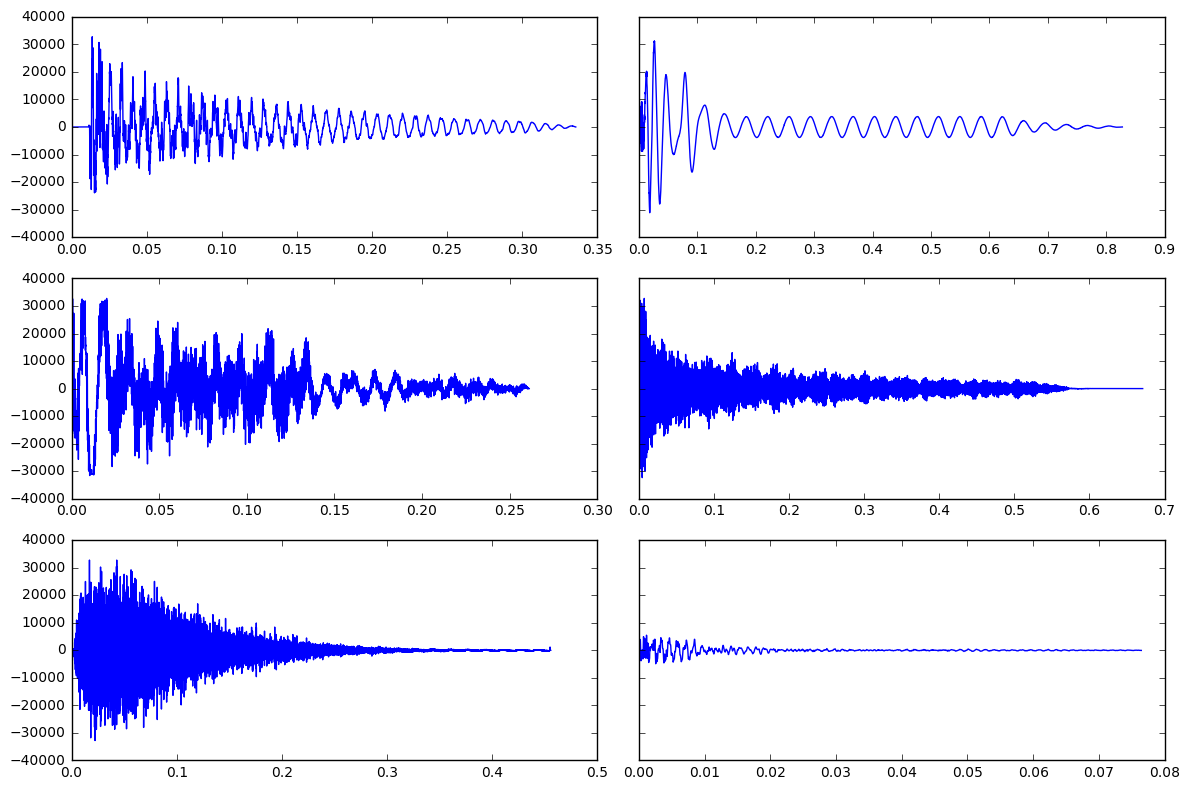

In [7]:
fig, axs = subplots(3, 2, sharey=True, figsize=(12, 8))
for ax, wf in zip(axs.reshape((6,)), selected):
    sr, w_signal = wavfile.read(wf)
    xs = arange(len(w_signal)) / float(sr)
    sca(ax)
    plot(xs, w_signal)
tight_layout()

### Dataset resumido

In [9]:
srs = []
durs = []
chs = []
valid_wavs = []
invalid_wavs = []
for wf in all_wavs:
    try:
        sr, w_signal = wavfile.read(wf)
        srs.append(sr)
        chs.append(w_signal.shape[1] if len(w_signal.shape) > 1 else 1)
        durs.append(len(w_signal) / float(sr))
        valid_wavs.append(wf)
    except Exception as e:
        invalid_wavs.append(wf)
assert len(set(chs)) == 1 and chs[0] == 1
assert all(durs > 0)
print 'Invalid wavs:'
print
for iwf in invalid_wavs:
    print iwf

Invalid wavs:

drums/Roland JV 1080/MaxV - Guiro.wav


set([44100])


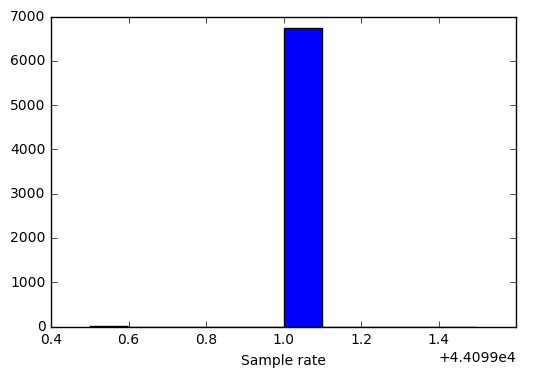

In [10]:
# Plot srs
srs = np.array(srs)
srs = srs
hist(srs)
xlabel('Sample rate')

print set(srs)
global_sr = srs[0]

Min durations (seg): [0.0003401360544217687, 0.0023356009070294786, 0.003038548752834467, 0.003061224489795918, 0.003832199546485261, 0.003832199546485261, 0.003832199546485261, 0.003832199546485261, 0.003832199546485261, 0.003945578231292517]
Max durations (seg): [14.68, 14.914081632653062, 16.211269841269843, 17.286780045351474, 18.812879818594105, 19.508049886621315, 21.005963718820862, 21.10426303854875, 21.116938775510203, 39.78546485260771]


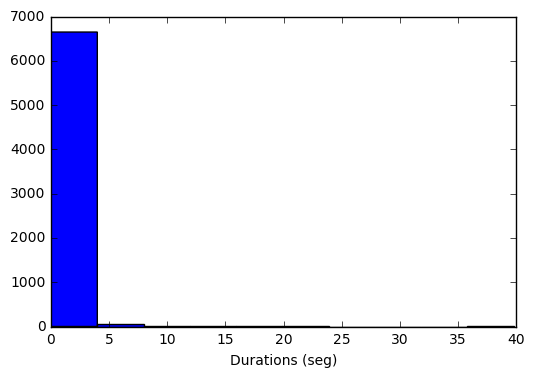

In [11]:
s_durs = sorted(durs)
print 'Min durations (seg):', s_durs[:10]
print 'Max durations (seg):', s_durs[-10:]
# Plot durs
hist(s_durs)
xlabel('Durations (seg)')

Count: 5834 (0.86%)


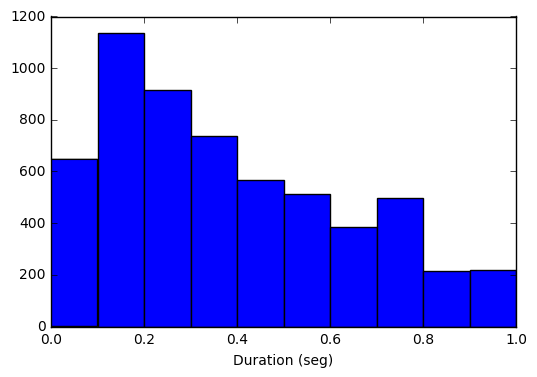

In [18]:
bins_l = linspace(0, 1, num=11)
under_sec = [d for d in s_durs if d <= 1]
hist(under_sec, bins=bins_l)
xlabel('Duration (seg)')
print 'Count: {} ({:.2f}%)'.format(len(under_sec), len(under_sec) / float(len(durs)))

In [13]:
under_sec_wavs = [wf for wf, dur in zip(valid_wavs, durs) if dur <= 1]

### Por tipos de ruido

In [14]:
by_type = collections.OrderedDict([(dt, []) for dt in drum_types + ['others']])
with_type = []

for wf in under_sec_wavs:
    is_of_type = False
    for dt in drum_types:
        if os.path.basename(wf).lower().find(dt) > 0:
            by_type[dt].append(wf)
            with_type.append((wf, dt))
            is_of_type = True
    if not is_of_type:
        by_type['others'].append(wf)
        with_type.append((wf, 'others'))

print '#total:', len(under_sec_wavs)
print
for k, v in by_type.items():
    print '#{}: {}'.format(k, len(v))

#total: 5834

#crash: 17
#tom: 419
#hat: 256
#snare: 587
#kick: 442
#others: 4113


In [15]:
intersections = [((k, k2), set(by_type[k]).intersection(set(by_type[k2])))
                 for idx, k in enumerate(by_type.keys())
                 for k2 in by_type.keys()[:idx]]
assert len([x for x in intersections if len(x[1]) > 0]) == 0  # Los conjuntos son disjuntos

In [20]:
by_type_avg = collections.OrderedDict([(k, np.zeros(global_sr)) for k in by_type.keys()])

for k, values in by_type.items():
    for wf in values:
        _, w_signal = wavfile.read(wf)
        by_type_avg[k][:len(w_signal)] += abs(w_signal)
    by_type_avg[k] = by_type_avg[k] / len(values)

by_type_sd = collections.OrderedDict([(k, np.zeros(global_sr)) for k in by_type.keys()])
    
for k, values in by_type.items():
    for wf in values:
        _, w_signal = wavfile.read(wf)
        by_type_sd[k][:len(w_signal)] += abs(abs((by_type_avg[k][:len(w_signal)])) - w_signal)
    by_type_sd[k] = by_type_sd[k] / len(values)

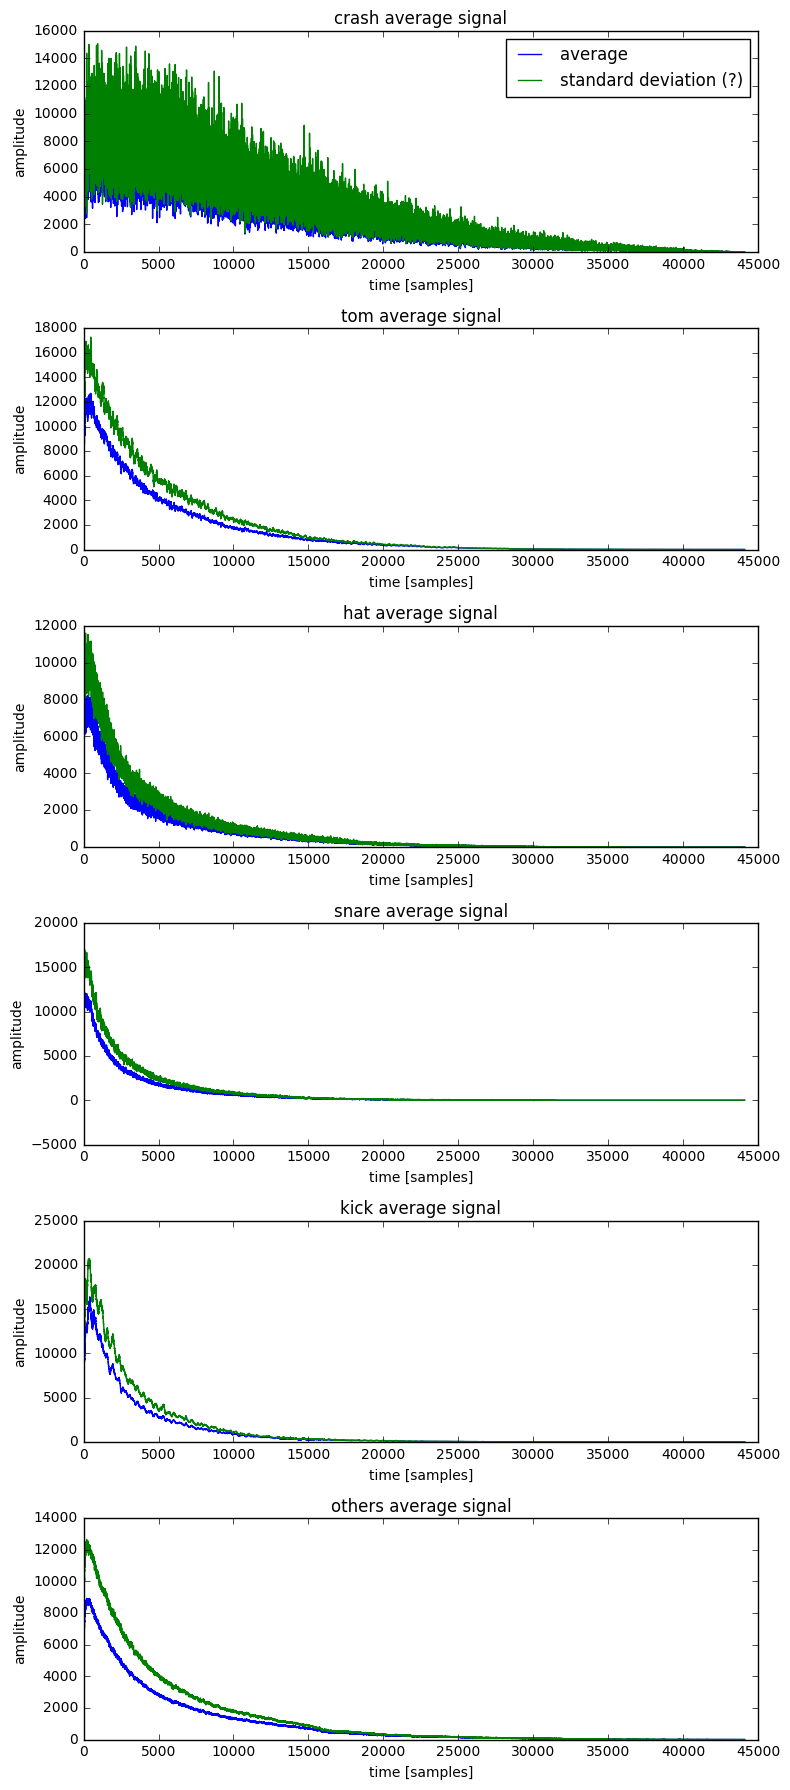

In [21]:
fig, axs = subplots(len(by_type), 1, figsize=(8, 3 * len(by_type)))
for idx, (ax, (k, avg)) in enumerate(zip(axs, by_type_avg.items())):
    sca(ax)
    plot(avg, label='average')
    plot(by_type_sd[k], label='standard deviation (?)')
    xlabel('time [samples]')
    ylabel('amplitude')
    title('{} average signal'.format(k))
    if idx == 0:
        legend()
tight_layout()

## 1 Layer Feed-forward NN

In [22]:
import tensorflow as tf

In [24]:
classes = by_type.keys()
classes_n = len(classes)

type_translate = dict([(dt, idx) for idx, dt in enumerate(classes)])
def to_one_hot(dt):
    ret = np.zeros(classes_n)
    ret[type_translate[dt]] = 1
    return ret

def to_signal(wf):
    ret = np.zeros(global_sr)
    sig = wavfile.read(wf)[1]
    ret[:len(sig)] = sig
    return ret

signal_one_hot_type = [(to_signal(wf), to_one_hot(dt))  # :: [(señal :: [int], clase en one hot :: [000100])]
                       for wf, dt in with_type]
all_signals, all_types = zip(*signal_one_hot_type)
all_signals = np.array(all_signals)
all_types = np.array(all_types)
print all_signals.shape
print all_types.shape

(5834, 44100)
(5834, 6)


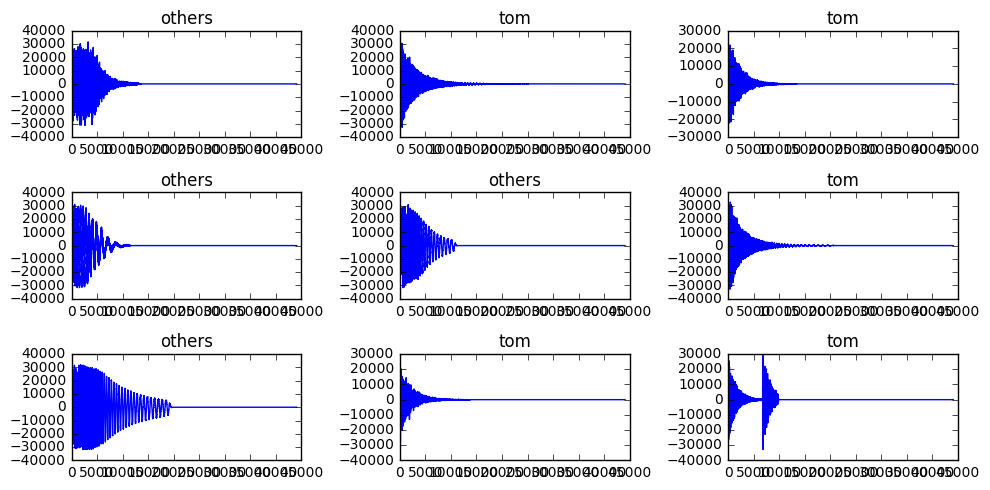

In [28]:
fig, axs = subplots(3, 3, figsize=(10, 5))
f_axs = axs.reshape(9)
for signal, t, ax in zip(all_signals[:9], all_types[:9], f_axs):
    sca(ax) 
    plot(signal)
    title(classes[argmax(t)])
tight_layout()

In [32]:
y_ = tf.placeholder(tf.float32, [None, classes_n])  # Thruth
x = tf.placeholder(tf.float32, [None, global_sr])  # Input
W = tf.Variable(tf.zeros([global_sr, classes_n]))  # Weights :: 
b = tf.Variable(tf.zeros([classes_n]))  # Bias

In [33]:
#y = tf.nn.softmax(tf.matmul(x, W) + b)
y = tf.matmul(x, W) + b 

In [34]:
cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [35]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [39]:
batch_size = 500
epochs = 60
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    accuracy_history = []
    for e_idx in xrange(epochs):
        random.shuffle(signal_one_hot_type)
        batch_n = int(math.ceil(len(signal_one_hot_type) / batch_size))
        it = iter(signal_one_hot_type)
        for b_idx in xrange(batch_n):
            batch_cases_and_type = [] 
            try:
                for _ in xrange(batch_size):
                    batch_cases_and_type.append(next(it))
            except StopIteration:
                pass
            
            b_signals, b_types = zip(*batch_cases_and_type)
            input_matrix = np.zeros((len(b_signals), global_sr))
            for idx, sig in enumerate(b_signals):
                input_matrix[idx][:len(sig)] = sig
                
            sess.run(train_step, feed_dict={x: input_matrix, y_: b_types})
            sys.stdout.write('\rEpoch: {}/{}, Batch: {}/{}, Last epoch accuracy: {}'.format(
                    e_idx + 1, epochs, b_idx + 1, batch_n, 
                    round(accuracy_history[-1], 4) if len(accuracy_history) > 0 else '-'))
        accuracy_history.append(sess.run(accuracy, feed_dict={x: all_signals, y_: all_types}))


Epoch: 60/60, Batch: 11/11, Last epoch accuracy: 0.7107

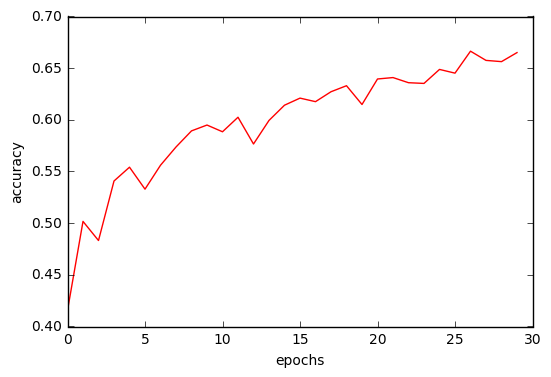

In [37]:
plot(accuracy_history, color='red')
xlabel('epochs') 
ylabel('accuracy')

## 2-Layer Feed-Forward NN

In [49]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, global_sr], name='input')  # Input
y_ = tf.placeholder(tf.float32, [None, classes_n], name='truth')  # Thruth

# NN Config  (based on: https://github.com/m2march/CADL/blob/master/session-2/lecture-2.ipynb)
layer_sizes = [100, 50]
activation = tf.sigmoid  # https://www.tensorflow.org/versions/r0.11/api_docs/python/nn/activation_functions_

last_output = x
last_output_size = global_sr
weights = []
biases = []
layer_sizes.append(classes_n)
for idx, ls in enumerate(layer_sizes):
    with tf.variable_scope('layer{}'.format(idx)):
        W = tf.Variable(tf.random_normal([last_output_size, ls]), 
                        name='weights', 
                        dtype=tf.float32)  # Weights
        b = tf.Variable(tf.random_normal([ls]),
                        name='bias', 
                        dtype=tf.float32)  # Bias
        h = tf.matmul(last_output, W) + b
        if activation is not None:
            h = activation(h)
            
        weights.append(W)
        biases.append(b)
            
        last_output = h
        last_output_size = ls
            
y = last_output

In [50]:
[op.name for op in tf.get_default_graph().get_operations()]

[u'input',
 u'truth',
 u'layer0/random_normal/shape',
 u'layer0/random_normal/mean',
 u'layer0/random_normal/stddev',
 u'layer0/random_normal/RandomStandardNormal',
 u'layer0/random_normal/mul',
 u'layer0/random_normal',
 u'layer0/weights',
 u'layer0/weights/Assign',
 u'layer0/weights/read',
 u'layer0/random_normal_1/shape',
 u'layer0/random_normal_1/mean',
 u'layer0/random_normal_1/stddev',
 u'layer0/random_normal_1/RandomStandardNormal',
 u'layer0/random_normal_1/mul',
 u'layer0/random_normal_1',
 u'layer0/bias',
 u'layer0/bias/Assign',
 u'layer0/bias/read',
 u'layer0/MatMul',
 u'layer0/add',
 u'layer0/Sigmoid',
 u'layer1/random_normal/shape',
 u'layer1/random_normal/mean',
 u'layer1/random_normal/stddev',
 u'layer1/random_normal/RandomStandardNormal',
 u'layer1/random_normal/mul',
 u'layer1/random_normal',
 u'layer1/weights',
 u'layer1/weights/Assign',
 u'layer1/weights/read',
 u'layer1/random_normal_1/shape',
 u'layer1/random_normal_1/mean',
 u'layer1/random_normal_1/stddev',
 u'la

In [51]:
cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

In [52]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
batch_size = 500
epochs = 30 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    accuracy_history = []
    for e_idx in xrange(epochs):
        random.shuffle(signal_one_hot_type)
        batch_n = int(math.ceil(len(signal_one_hot_type) / batch_size))
        it = iter(signal_one_hot_type)
        for b_idx in xrange(batch_n):
            batch_cases_and_type = [] 
            try:
                for _ in xrange(batch_size):
                    batch_cases_and_type.append(next(it))
            except StopIteration:
                pass
            
            b_signals, b_types = zip(*batch_cases_and_type)
            input_matrix = np.zeros((len(b_signals), global_sr))
            for idx, sig in enumerate(b_signals):
                input_matrix[idx][:len(sig)] = sig
                
            sess.run(train_step, feed_dict={x: input_matrix, y_: b_types})
            sys.stdout.write('\rEpoch: {}/{}, Batch: {}/{}, Last epoch accuracy: {}'.format(
                    e_idx + 1, epochs, b_idx + 1, batch_n, 
                    round(accuracy_history[-1], 4) if len(accuracy_history) > 0 else '-'))
        accuracy_history.append(sess.run(accuracy, feed_dict={x: all_signals, y_: all_types}))


Epoch: 12/30, Batch: 6/11, Last epoch accuracy: 0.7017

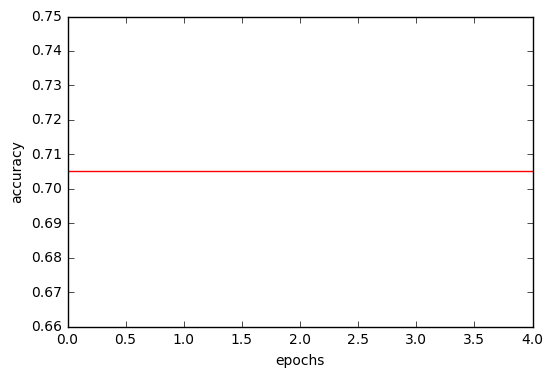

In [48]:
plot(accuracy_history, color='red')
xlabel('epochs') 
ylabel('accuracy')